[[0.83464567 0.56299213 0.53543307 0.61811024 0.99212598 0.2480315
  0.64566929 0.87401575 0.77165354 0.24015748 0.49212598 0.67716535
  0.37795276 0.20472441 0.97637795 0.52362205 0.28740157 0.27952756
  0.17322835 0.81889764 0.92519685 0.90944882 0.7480315  0.72047244
  0.84645669 0.66929134 0.1496063  0.07086614 0.12598425 0.12992126
  0.72834646 0.32677165 0.50787402 0.72834646 0.77952756 0.37007874
  0.89370079 0.34645669 0.22440945 0.01181102 0.50393701 0.41338583
  0.97244094 0.51968504 0.62598425 0.81102362 0.03937008 0.03149606
  0.75590551 0.27165354 0.26377953 0.33858268 0.47637795 0.2519685
  0.21259843 0.65354331 0.80314961 0.95275591 0.12204724 0.61811024
  0.18503937 0.33464567 0.18110236 0.12204724 0.15354331 0.18110236
  0.87795276 0.1023622  0.86614173 0.42125984 0.61023622 0.40551181
  0.87401575 0.00787402 0.48031496 0.01968504 0.08661417 0.96850394
  0.40944882 0.57086614 0.66141732 0.78346457 0.9015748  0.76771654
  0.4015748  0.13779528 0.27559055 0.31889764 0.51

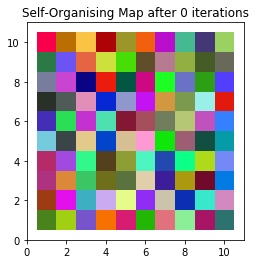

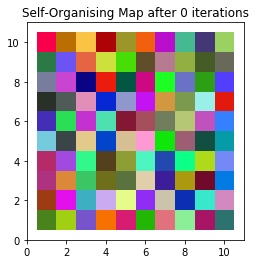

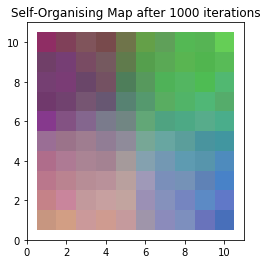

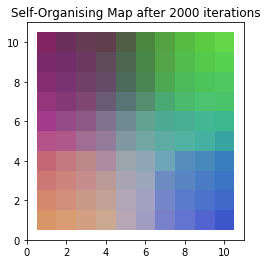

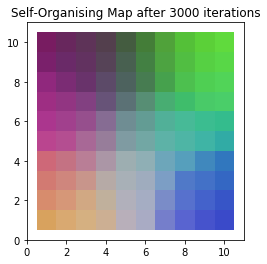

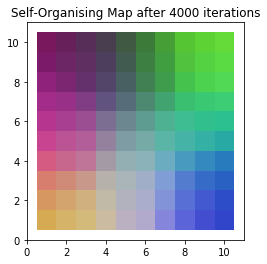

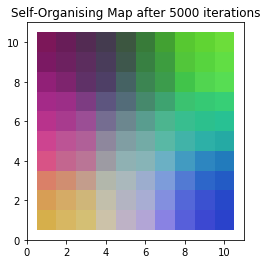

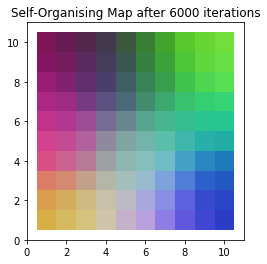

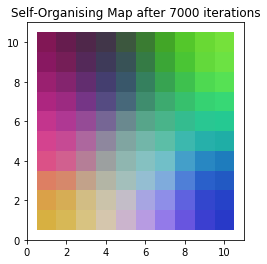

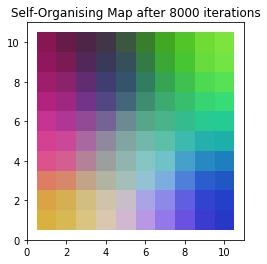

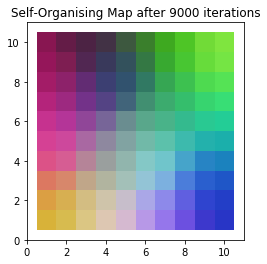

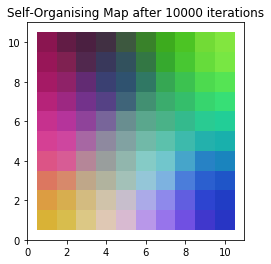

In [2]:
from __future__ import division

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches

def plot_som(net, n_iterations):
    fig = plt.figure()
    # setup axes
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim((0, net.shape[0]+1))
    ax.set_ylim((0, net.shape[1]+1))
    ax.set_title('Self-Organising Map after %d iterations' % n_iterations)

    # plot the rectangles
    for x in range(1, net.shape[0] + 1):
        for y in range(1, net.shape[1] + 1):
            ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                     facecolor=net[x-1,y-1,:],
                     edgecolor='none'))



def find_bmu(t, net, m):
            """
                Find the best matching unit for a given vector, t, in the SOM
                Returns: a (bmu, bmu_idx) tuple where bmu is the high-dimensional BMU
                         and bmu_idx is the index of this vector in the SOM
            """
            bmu_idx = np.array([0, 0])
            # set the initial minimum distance to a huge number
            min_dist = np.iinfo(np.int).max
            # calculate the high-dimensional distance between each neuron and the input
            for x in range(net.shape[0]):
                for y in range(net.shape[1]):
                    w = net[x, y, :].reshape(m, 1)
                    # don't bother with actual Euclidean distance, to avoid expensive sqrt operation
                    sq_dist = np.sum((w - t) ** 2)
                    if sq_dist < min_dist:
                        min_dist = sq_dist
                        bmu_idx = np.array([x, y])
            # get vector corresponding to bmu_idx
            bmu = net[bmu_idx[0], bmu_idx[1], :].reshape(m, 1)
            # return the (bmu, bmu_idx) tuple
            return (bmu, bmu_idx)


def decay_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)

def decay_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)

def calculate_influence(distance, radius):
    return np.exp(-distance / (2 * (radius ** 2)))


def train(data, n_iterations, net, init_radius, time_constant, init_learning_rate):
    n=data.shape[1]
    m=data.shape[0]

    for i in range(n_iterations):
        # print('Iteration %d' % i)

        if (i % 1000)==0:
            plot_som(net, i)
        # select a training example at random
        t = data[:, np.random.randint(0, n)].reshape(np.array([m, 1]))

        # find its Best Matching Unit
        bmu, bmu_idx = find_bmu(t, net, m)

        # decay the SOM parameters
        r = decay_radius(init_radius, i, time_constant)
        l = decay_learning_rate(init_learning_rate, i, n_iterations)

        # now we know the BMU, update its weight vector to move closer to input
        # and move its neighbours in 2-D space closer
        # by a factor proportional to their 2-D distance from the BMU
        for x in range(net.shape[0]):
            for y in range(net.shape[1]):
                w = net[x, y, :].reshape(m, 1)
                # get the 2-D distance (again, not the actual Euclidean distance)
                w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
                # if the distance is within the current neighbourhood radius
                if w_dist <= r ** 2:
                    # calculate the degree of influence (based on the 2-D distance)
                    influence = calculate_influence(w_dist, r)
                    # now update the neuron's weight using the formula:
                    # new w = old w + (learning rate * influence * delta)
                    # where delta = input vector (t) - old w
                    new_w = w + (l * influence * (t - w))
                    # commit the new weight
                    net[x, y, :] = new_w.reshape(1, 3)


def generate_data():
    # 8 colours as initial test set
    #raw_data = np.array([[1, 0, 0], [0, 1, 0],
    #                     [0, 0.5, 0.25], [0, 0, 1],
    #                     [0, 0, 0.5], [1, 1, 0.2],
    #                     [1, 0.4, 0.25], [1, 0, 1]]).T * 255
    # or use random colours
    raw_data = np.random.randint(0, 255, (3, 100))

    data = raw_data / raw_data.max()
    return data


def create_som(width_som,height_som, number_features):
    # setup random weights between 0 and 1
    # weight matrix needs to be one m-dimensional vector for each neuron in the SOM
    net = np.random.random((width_som, height_som, number_features))
    return net

def main():
    data=generate_data()
    print(data)
    # establish variables based on data
    number_features=3

    width_som=10
    height_som=10
    n_iterations = 10000
    init_learning_rate = 0.01

    # initial neighbourhood radius
    init_radius = max(width_som, height_som) / 2
    # radius decay parameter
    time_constant = n_iterations / np.log(init_radius)
    net=create_som(width_som, height_som, number_features)

    plot_som(net, 0)
    train(data, n_iterations, net, init_radius, time_constant, init_learning_rate)
    plot_som(net, n_iterations)
    plt.show()


main()